# Pre-processing

Explore possible pre-processing steps for time series.

Based on Daydulo et al. 2020 - Deep learning based fetal distress detection from time frequency representation of cardiotocogram signal using Morse wavelet: research study

## Import packages

In [1]:
from dataclasses import dataclass
import numpy as np
import os
import pandas as pd

## Load data

In [2]:
# Define file paths
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    data = './data_csv'
    meta = 'metadata.csv'


paths = Paths()

In [3]:
# Set up dictionary for CSV files
csv_files = dict()

# Load files into dictionary
filenames = os.listdir(paths.data)
for file in filenames:
    # Get filename and file extension
    filename, file_extension = os.path.splitext(os.path.join(paths.data, file))
    # Load data and save to dict with filename (without path/csv) as index
    if file_extension == '.csv':
        filename_short = filename.split('/')[-1]
        csv_files[filename_short] = pd.read_csv(os.path.join(paths.data, file))

In [4]:
# Load meta data
metadata = pd.read_csv(os.path.join(paths.data, paths.meta),
                       index_col='parameter')

## View example of 1001

In [5]:
csv_1001 = csv_files['1001']
csv_1001.head()

,seconds,FHR,UC
0,0,150.50,7.0
1,1,150.50,8.5
2,2,151.00,8.5
3,3,151.25,7.5
4,4,151.25,9.5


In [6]:
meta_1001 = metadata['1001']
meta_1001.head()

parameter
pH         7.14
BDecf      8.14
pCO2       7.70
BE       -10.50
Apgar1     6.00
Name: 1001, dtype: float64

<Axes: >

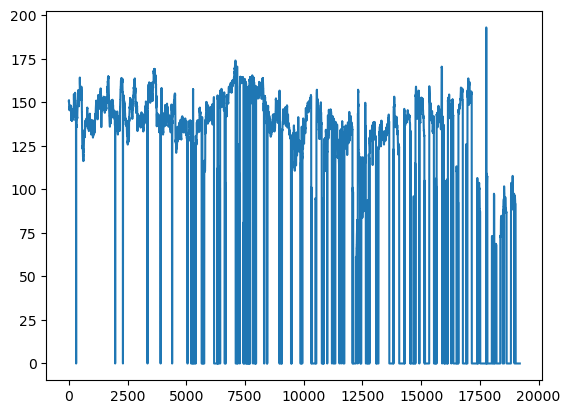

In [7]:
# Used fetal heart rate from signal 1001
fhr = csv_1001['FHR']
fhr.plot()

## Replace 0 with NaN

<Axes: >

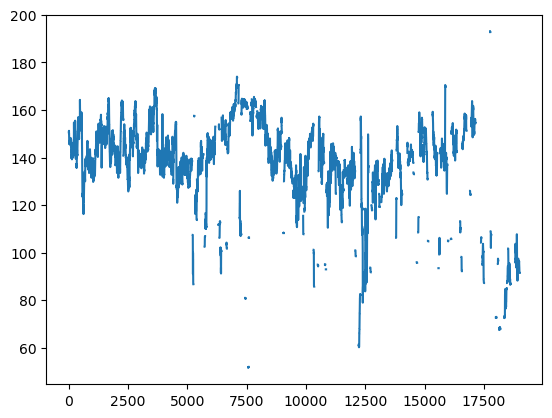

In [8]:
# Replace 0 with NaN
fhr.replace(0, np.nan, inplace=True)
fhr.plot()

## Remove NaN if occur for more than 15 consecutive seconds

<Axes: >

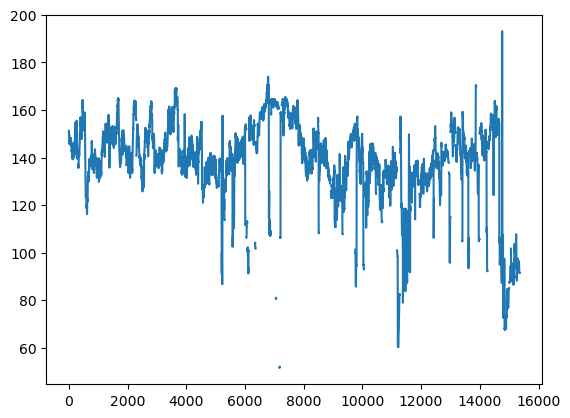

In [9]:
# Remove NaN if they occured for more than 15 seconds consecutively
na = fhr.isnull()
fhr = fhr[~(fhr.groupby(na.ne(na.shift()).cumsum().values).transform('size').ge(16) & na)].reset_index(drop=True)
fhr.plot()

## Outlier detection

Less than 50bpm and more than 200bpm are not physiologic and are outliers.

In [10]:
# Set oulers to NaN
fhr[fhr < 50] = np.nan
fhr[fhr > 200] = np.nan

## Use linear interpolation for remaining missing values

Linear interpolation treats values as equally spaced, how it works:
* 0 N N 3 becomes 0 1 2 3
* N 1 2 3 becomes 0 1 2 3
* 0 1 N N becomes 0 1 1 1

<Axes: >

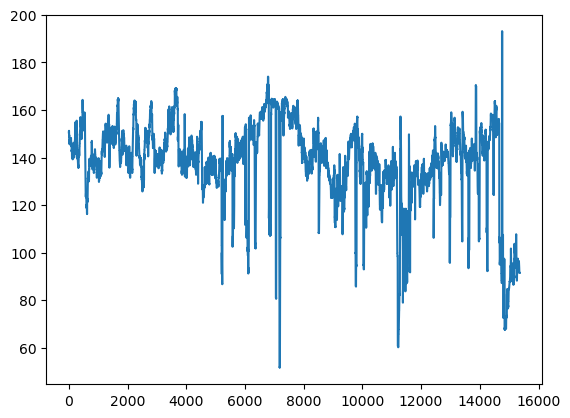

In [11]:
# Replace missing values using linear interpolation
fhr = fhr.interpolate(method='linear')
fhr.plot()

## Spike detection

Points of FHR signal more than 25 beat from the previous adjacent beat are not physiologic and are unrealistic.

<Axes: >

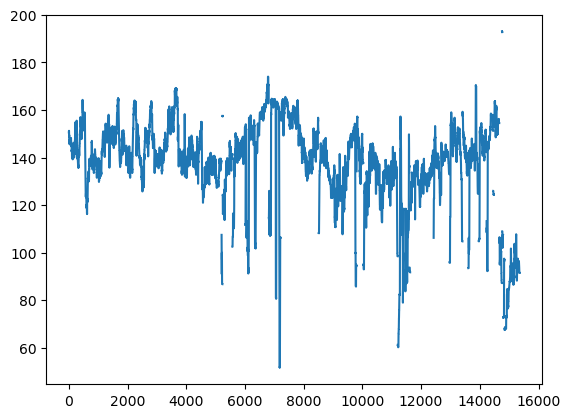

In [12]:
# Find how each value has changed from the prior value
diff = fhr - fhr.shift()

# Where difference is more than +- 25, set as NaN
fhr[(diff > 25) | (diff < -25)] = np.nan

fhr.plot()

In [13]:
null_ind = fhr[fhr.isnull()].index
null_ind = null_ind.append([null_ind + 1, null_ind + 2,
                            null_ind - 1, null_ind - 2]).sort_values()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(fhr[null_ind])

5199     138.50
5200     138.50
5201        NaN
5202     107.50
5203     103.25
5228      86.75
5229      86.75
5230        NaN
5231     157.50
5232     157.50
5238     157.50
5239     157.50
5240        NaN
5241     124.25
5242     124.25
5571     141.25
5572     141.25
5573        NaN
5574     102.50
5575     102.50
6003     153.00
6004     153.00
6005        NaN
6006     111.75
6007     111.75
6809     170.50
6810     170.50
6811        NaN
6812     114.50
6813     114.50
7208     106.25
7209     106.25
7210        NaN
7211     158.50
7212     158.50
8507     150.50
8508     150.50
8509        NaN
8510     108.25
8511     108.50
9799      94.50
9800      94.50
9801        NaN
9802     134.25
9803     137.25
10028    137.75
10029    137.75
10030       NaN
10031     95.00
10032     95.00
11201     98.50
11202     98.50
11203       NaN
11204     61.25
11205     61.25
11414    118.25
11415    118.25
11416       NaN
11417     86.75
11418     86.75
11606    136.25
11607    136.25
11608   

<Axes: >

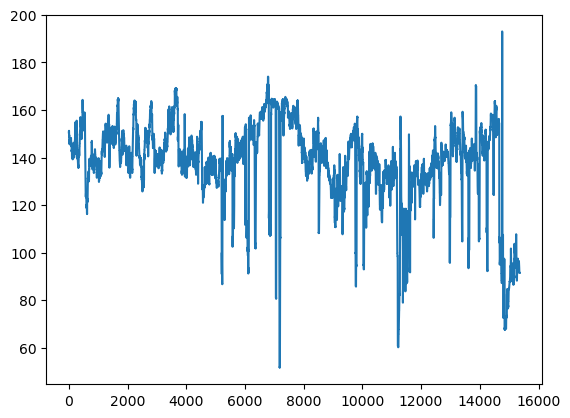

In [14]:
# Replace missing values using linear interpolation
fhr = fhr.interpolate(method='linear')
fhr.plot()

In [15]:
# Find how each value has changed from the prior value
diff = fhr - fhr.shift()

In [16]:
((diff > 25) | (diff < -25)).value_counts()

FHR
False    15349
True        14
Name: count, dtype: int64

Problem with this is you still have to have those steps to get to that spike, if the spike had beats next to each other <= 25 difference.